# DenseNet Architecture
Todo: Discussion

In [1]:
import os
import pathlib
from glob import glob

import tensorflow as tf
from bcd.model.repo import ModelRepo
from bcd.model.factory import DenseNetFactory
from bcd.model.visual import X4LearningVisualizer
from bcd.model.transfer import thaw
from bcd.model.callback import CheckpointCallbackFactory

In [2]:
batch_size = 32
input_shape = (224,224,3)
output_shape = 1

# Training Params
initial_epochs = 100  # Number of epochs to train for feature extraction
fine_tune_epochs = 50  # Number of epochs for each fine tune session
initial_learning_rate = 0.0001  # Base learning rate for the Adam optimizer 
loss = "binary_crossentropy"
activation = "sigmoid"

# Early stop callback parameters
monitor = "val_loss"  # Monitor validation loss for early stopping
patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.

# ModelCheckpoint Callback parameters
location = "models/"
mode = "auto"
save_weights_only = False
save_best_only = True
save_freq = "epoch"
verbose = 1

# DenseNet 
metric = "accuracy"

# Data Params
train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

## Preliminaries - Callbacks
Create a callback checkpoint factory which will be used to generate a callback for models at various stages. We'll also create an early stopping callback which monitors validation loss and stops training when it hasn't improved in patience = 3 epochs.

In [3]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback_factory = CheckpointCallbackFactory(location=location,                                     
                                    mode=mode, 
                                    monitor=monitor,
                                    save_weights_only=save_weights_only, 
                                    save_best_only=save_best_only, 
                                    save_freq=save_freq,
                                    verbose=verbose)

In [4]:
# Create an early stopping callback that will stop training if validation loss doesn't improve in n epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights)

## Load Data

In [5]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## DenseNet Transfer Learning Model

In [6]:
def get_model():
    # Instantiate a Densenet model factory and create the Densenet transfer learning model
    factory = DenseNetFactory()
    densenet = factory.create(input_shape=input_shape, 
                            output_shape=output_shape, 
                            learning_rate=initial_learning_rate, 
                            trainable=False, 
                            loss=loss, 
                            activation=activation, 
                            metric=metric)
    return DenseNetFactory
    # Let's summarize the model and confirm that trainable parameters are limited to our classification model.
densenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

As expected, only the 1921 parameters in the output layer are trainable. The DenseNet model occupies the 5th layer in our overall model. This will be relevant at the fine-tuning stage as we target layers in the DenseNet model to thaw.

Let's create a checkpoint callback and fit the model with early stopping.

In [7]:
def feature_extraction(model: tf.keras.Model) -> tf.keras.callbacks.History:
    # Obtain the callback from the factory.
    checkpoint_callback = checkpoint_callback_factory(name="densenet", stage="feature_extraction")
    # Fit the model with our callbacks.
    history = model.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback, early_stop_callback])
    return history

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.5701
Epoch 1: val_loss improved from inf to 0.65752, saving model to models/densenet/densenet_feature_extraction_01-val_loss_0.66.keras
7/7 [==============================] - 68s 7s/step - loss: 0.7293 - accuracy: 0.5701 - val_loss: 0.6575 - val_accuracy: 0.6909
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.5611
Epoch 2: val_loss improved from 0.65752 to 0.65116, saving model to models/densenet/densenet_feature_extraction_02-val_loss_0.65.keras
7/7 [==============================] - 51s 7s/step - loss: 0.7043 - accuracy: 0.5611 - val_loss: 0.6512 - val_accuracy: 0.6909
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.5385
Epoch 3: val_loss improved from 0.65116 to 0.64969, saving model to models/densenet/densenet_feature_extraction_03-val_loss_0.65.keras
7/7 [==============================] - 49s 7s/step - loss: 0.7008 

Our model checkpoints have been created for future reference.  Let's check the learning curves.

In [ ]:
def load_model(name: str) -> tf.keras.Model:
    

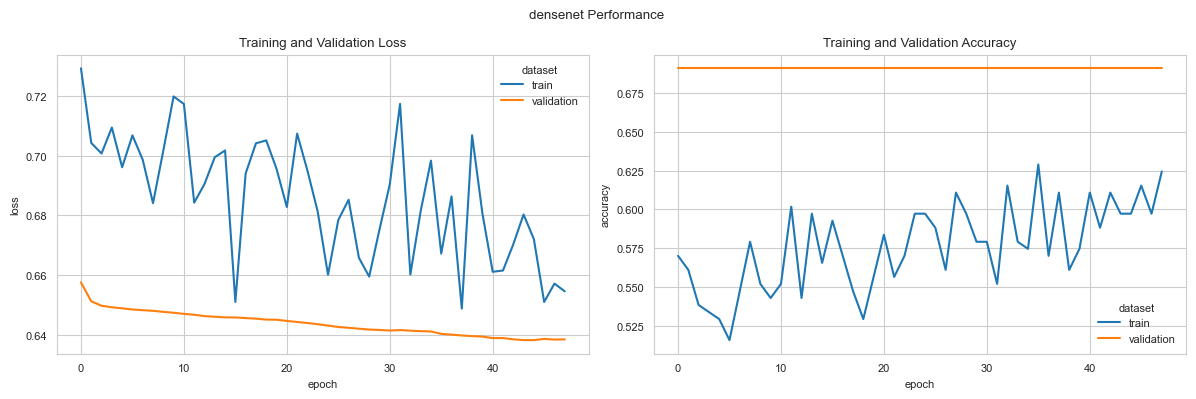

In [8]:
x4v = X4LearningVisualizer(name="densenet")
x4v(history=densenet_history)

Excellent. We can now move on to the fine tuning stage.

## Fine Tuning 
Our objective is to adapt the DenseNet201 model, which was trained on the ImageNet dataset, to our target domain, biomedical imaging, specifically, digital mammography. An iterative-gradual fine-tuning approach is undertaken in which the model progressively adapts to the target domain by gradually unfreezing layers and training the model on the CBIS-DDSM data.

A common approach is to unfreeze the top layer, train the model until convergence, then unfreeze the next top layer, and so on. However, the DenseNet model has over 700 layers making this approach impractical. Rather than unfreezing the layers one at a time, we will adopt a gradual unfreezing of layer groups. The number of layers in each group will range from 1 to 707 on a logarithmic scale. Concretely, the unfreezing schedule will be as follows:

```{table} Gradual Fine-Tuning Schedule
| Layer Group | Group Size | Learning Rate |
|-------------|------------|---------------|
| 1           | 1          | 1.00E-05      |
| 2           | 5          | 1.00E-06      |
| 3           | 27         | 1.00E-07      |
| 4           | 137        | 1.00E-08      |
| 5           | 707        | 1.00E-09      |
```

Each fine-tuning session will trained until convergence.


In [9]:
gradual_fine_tuning_schedule = {1: {"layers": 1, "learning_rate": 1e-5},
                                2: {"layers": 5, "learning_rate": 1e-6},
                                3: {"layers": 27, "learning_rate": 1e-7},
                                4: {"layers": 137, "learning_rate": 1e-8},
                                5: {"layers": 707, "learning_rate": 1e-9},
                                }

#### Fine Tune Session 1

In [11]:
fine_tune_session = 1
epochs = densenet_history.epoch[-1] + fine_tune_epochs # We pick up where we left off
densenet_base_layer = 5 # Layer of the DenseNet base model

# Order up a checkpoint callback
name="densenet"
stage="fine_tuning_session_1"
checkpoint_callback = checkpoint_callback_factory(name=name, stage=stage)

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate =gradual_fine_tuning_schedule[fine_tune_session]["layers"])

# Decay the learning rate
learning_rate = gradual_fine_tuning_schedule[fine_tune_session]["learning_rate"]

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

# Fit the model
densenet_history = densenet.fit(train_ds_10, epochs=epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

# Visualize the learning
x4v(history=densenet_history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________
Epoch 48/97
1/7 [===>..........................] - ETA: 5:24 - loss: 0.6733 - accuracy: 0.5312

#### Fine Tune Session 2

In [ ]:
fine_tune_session = 2
epochs = densenet_history.epoch[-1] + fine_tune_epochs 

# Order up a checkpoint callback
name="densenet"
stage="fine_tuning_session_2"
checkpoint_callback = checkpoint_callback_factory(name=name, stage=stage)

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate =gradual_fine_tuning_schedule[fine_tune_session]["layers"])

# Decay the learning rate
learning_rate = gradual_fine_tuning_schedule[fine_tune_session]["learning_rate"]

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

# Fit the model
densenet_history = densenet.fit(train_ds_10, epochs=epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

# Visualize the learning
x4v(history=densenet_history)

#### Fine Tune Session 3

In [ ]:
fine_tune_session = 3
epochs = densenet_history.epoch[-1] + fine_tune_epochs 

# Order up a checkpoint callback
name="densenet"
stage="fine_tuning_session_3"
checkpoint_callback = checkpoint_callback_factory(name=name, stage=stage)

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate =gradual_fine_tuning_schedule[fine_tune_session]["layers"])

# Decay the learning rate
learning_rate = gradual_fine_tuning_schedule[fine_tune_session]["learning_rate"]

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

# Fit the model
densenet_history = densenet.fit(train_ds_10, epochs=epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

# Visualize the learning
x4v(history=densenet_history)

#### Fine Tune Session 4

In [ ]:
fine_tune_session = 4
epochs = densenet_history.epoch[-1] + fine_tune_epochs 

# Order up a checkpoint callback
name="densenet"
stage="fine_tuning_session_4"
checkpoint_callback = checkpoint_callback_factory(name=name, stage=stage)

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate =gradual_fine_tuning_schedule[fine_tune_session]["layers"])

# Decay the learning rate
learning_rate = gradual_fine_tuning_schedule[fine_tune_session]["learning_rate"]

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

# Fit the model
densenet_history = densenet.fit(train_ds_10, epochs=epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

# Visualize the learning
x4v(history=densenet_history)

#### Fine Tune Session 5

In [ ]:
fine_tune_session = 5
epochs = densenet_history.epoch[-1] + fine_tune_epochs 

# Order up a checkpoint callback
name="densenet"
stage="fine_tuning_session_5"
checkpoint_callback = checkpoint_callback_factory(name=name, stage=stage)

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate =gradual_fine_tuning_schedule[fine_tune_session]["layers"])

# Decay the learning rate
learning_rate = gradual_fine_tuning_schedule[fine_tune_session]["learning_rate"]

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

# Fit the model
densenet_history = densenet.fit(train_ds_10, epochs=epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])

# Visualize the learning
x4v(history=densenet_history)